### Introductory Overview of PyMC

PyMC is an open source probabilistic programming framework written in Python that uses PyTensor to compute gradients via automatic differentiation, as well as compiling probabilistic programs on-the-fly to one of a suite of computational backends for increased speed.

A Motivating Example: Linear Regression

Generating data:We can simulate some artificial data from this model using only NumPy’s random module, and then use PyMC to try to recover the corresponding parameters. We are intentionally generating the data to closely correspond to the PyMC model structure.

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [4]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

Here is what the simulated data look like. We use the plotting library matplotlib to visualize the data.

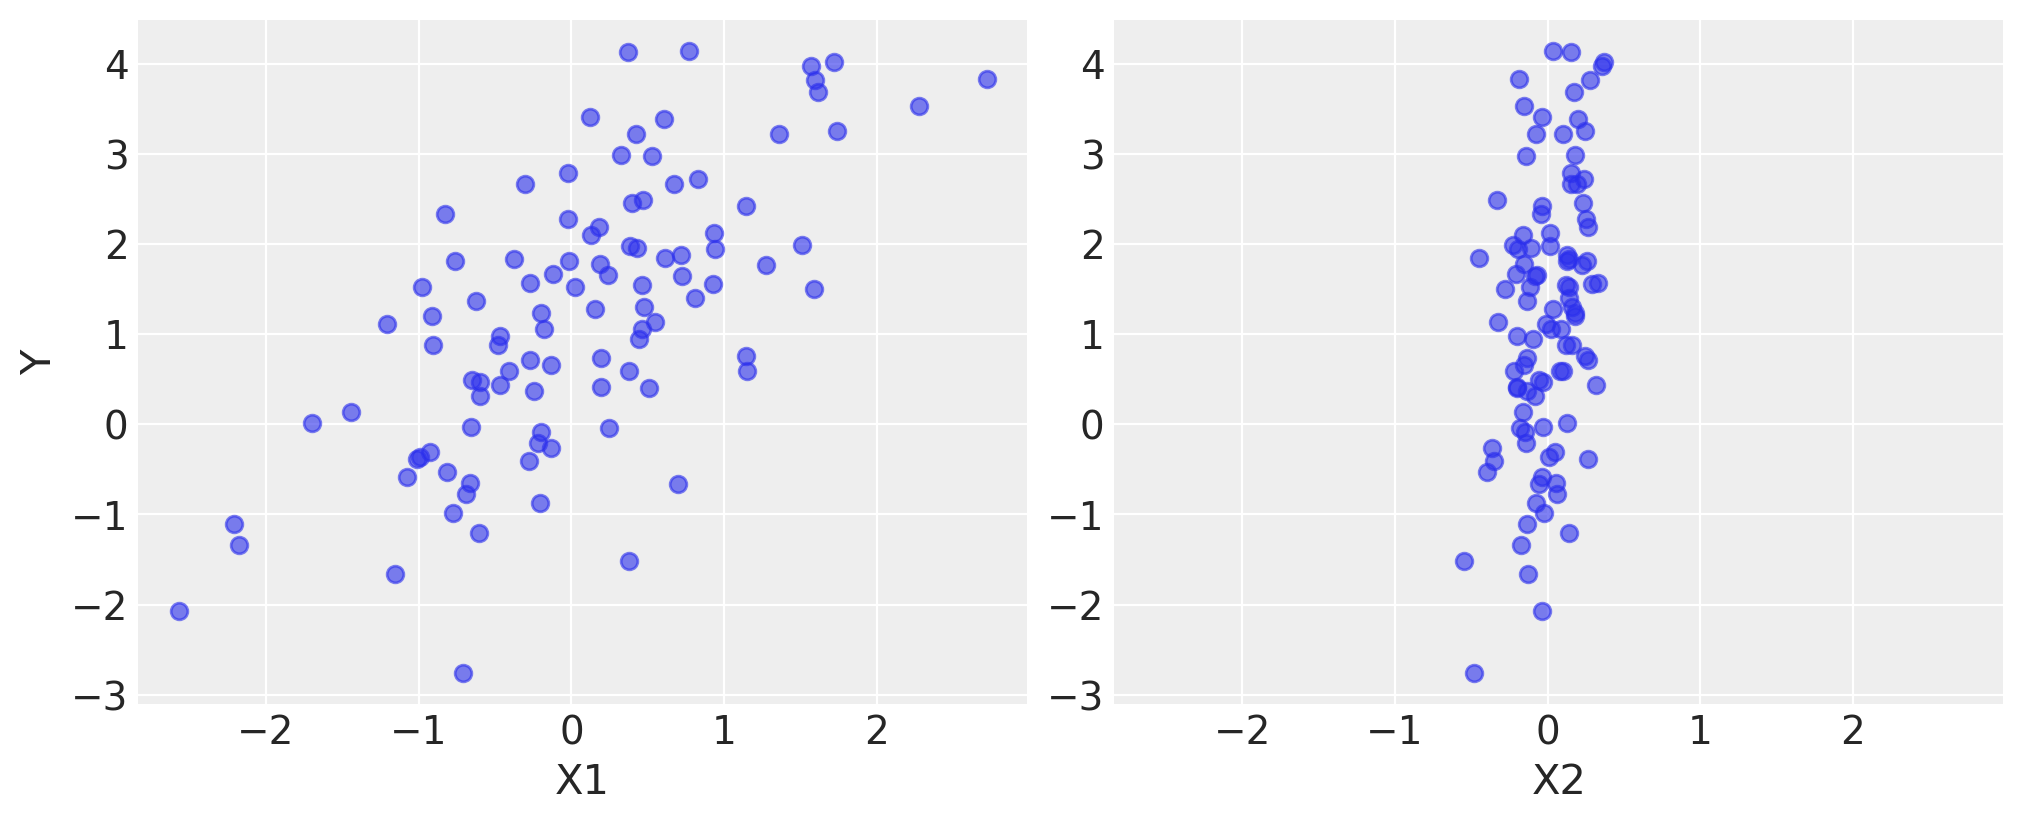

In [5]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

Model Specification

In [6]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.20.0


In [7]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [8]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


/Users/h6x/anaconda3/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets"
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [9]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [10]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)> Size: 160B
array([[1.15952677, 1.24201136, 1.04598009, 1.20503946, 1.24731563],
       [1.22262133, 1.06590697, 1.18092472, 1.15364954, 1.15190235],
       [1.23566835, 1.23566835, 1.23829191, 1.0757701 , 1.07892609],
       [1.10599132, 1.3414241 , 0.98325711, 1.14039791, 1.20255038]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 40B 0 1 2 3 4

In [11]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    slice_idata = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [beta]
>Slice: [sigma]


/Users/h6x/anaconda3/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets"
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1 seconds.


### Posterior analysis

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order.

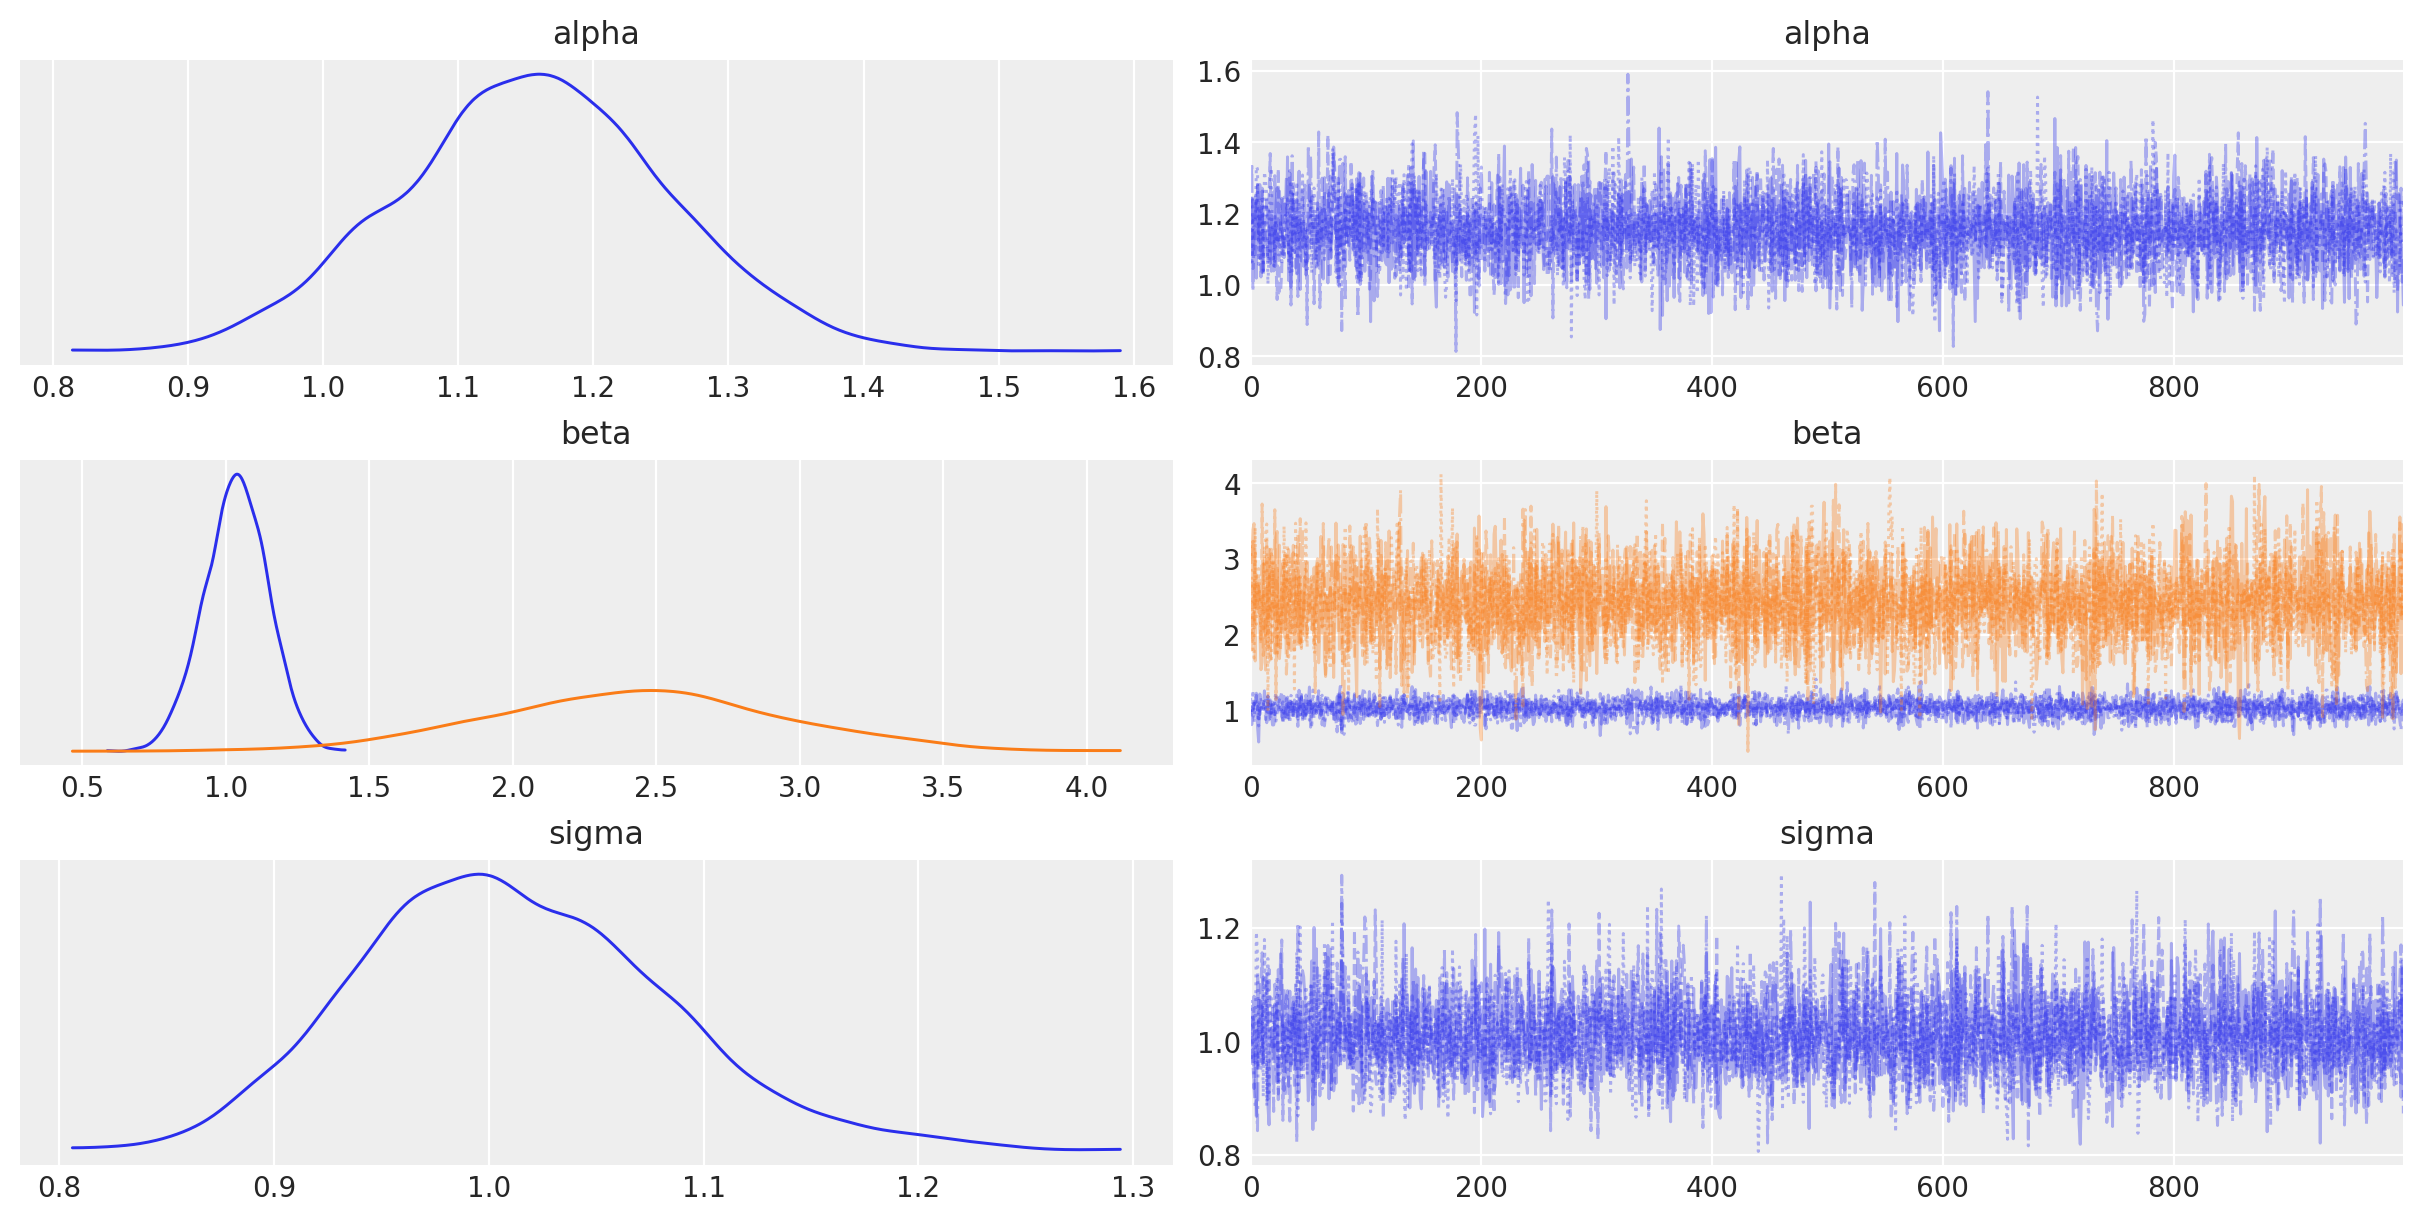

In [12]:
az.plot_trace(idata, combined=True);

In [13]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.16,0.10,0.96,1.34,0.00,0.00,6844.15,3406.46,1.0
beta[0],1.04,0.11,0.83,1.25,0.00,0.00,5884.26,3226.78,1.0
beta[1],2.43,0.52,1.48,3.41,0.01,0.01,5671.18,3158.20,1.0
sigma,1.01,0.07,0.88,1.14,0.00,0.00,4680.20,3280.33,1.0


### Case study 1: Educational Outcomes for Hearing-impaired Children

In [14]:
test_scores = pd.read_csv(pm.get_data("test_scores.csv"), index_col=0)
test_scores.head()

,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,40,0,2.0,2.0,False,NaN,55,1.0,NaN,False,False
1,31,1,0.0,NaN,False,0.0,53,0.0,0.0,False,False
2,83,1,1.0,1.0,True,0.0,52,1.0,NaN,False,True
3,75,0,3.0,NaN,False,0.0,55,0.0,1.0,False,False
5,62,0,0.0,4.0,False,1.0,50,0.0,NaN,False,False


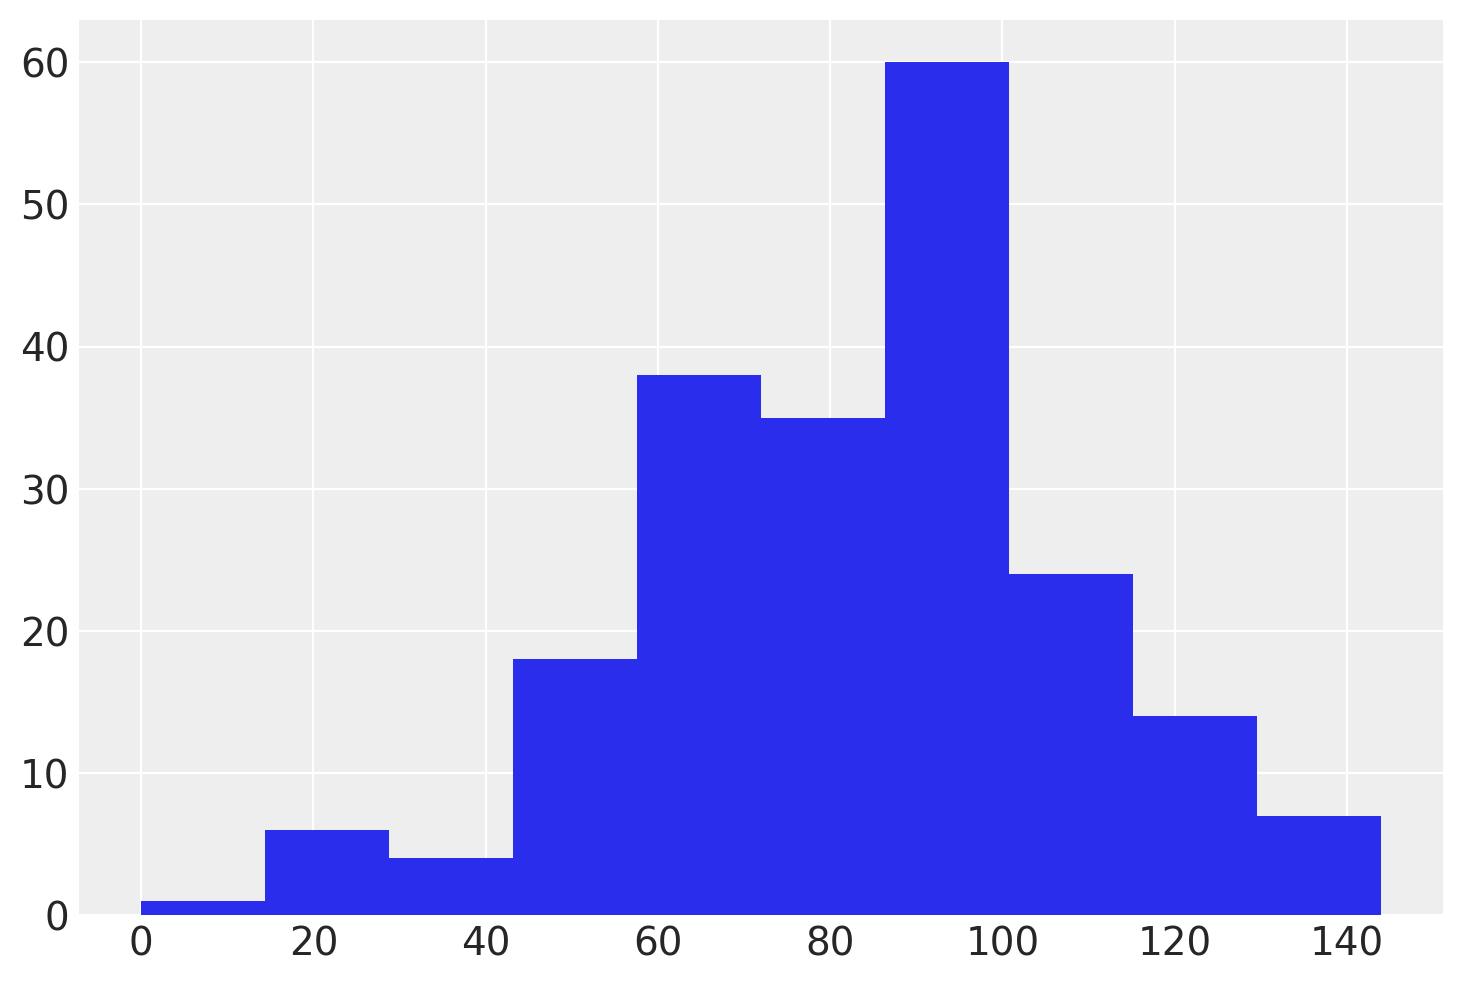

In [15]:
test_scores["score"].hist();

In [16]:
# Dropping missing values is a very bad idea in general, but we do so here for simplicity
X = test_scores.dropna().astype(float)
y = X.pop("score")

# Standardize the features
X -= X.mean()
X /= X.std()

N, D = X.shape

In [17]:
X.head()

,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
7,-1.004938,1.078165,2.227502,2.480475,1.782293,-0.978004,1.179344,0.616250,-0.772789,1.132532
12,0.985234,-0.080289,-0.911722,-0.399157,-0.555520,-1.562492,1.179344,0.616250,1.281203,-0.874235
14,-1.004938,1.078165,-0.911722,-0.399157,-0.555520,1.359947,1.179344,0.616250,1.281203,1.132532
19,0.985234,-1.238742,1.181094,-0.399157,-0.555520,-0.978004,1.179344,0.616250,-0.772789,1.132532
21,0.985234,-0.080289,1.181094,-0.399157,1.782293,1.359947,-0.839533,-1.606652,1.281203,1.132532
